This notebook allows the complexity / long-range coefficient plots to be reconstructed. Please note this process is non-trivial and requires the use of an external software package CrystIT. The instructions have been provided here to ensure complete reproducability.

Import relevant libraries. Please set the number of cpu cores you wish to dedicate to the notebook in the code block below. The default is 1.

In [2]:
import pandas as pd
import pymatgen as pyg
import matplotlib.pyplot as plt
import pickle as pk
import numpy as np
from tqdm import tqdm
import sklearn
import matplotlib as mlp

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
plt.style.use(['science',"no-latex"])
mlp.rc('font', family='sans-serif') 

tqdm.pandas()
num_cpus = 8

In order to obtain the complexity analysis plots, it is necessary to dump the structures in a hdf5 data file to a folder of cifs so that CrystIT can operate on it. We perform this first. Please run predict_reproduce.py on a band gap model and a formation energy model and preserve the file Long_Range_Coefficients.csv that gets produced each time. Please rename the output from the band gap model "Long_Range_Coefficients_formationenergy.csv" and the output from the formation energy model "Long_Range_Coefficients_bandgap.csv" This file contains the long-range coefficients for each attention head and a pickled pymatgen structure for every crystal in the dataset. Our first objective is to obtain the primitive unit cell from all of these structures and dump them into folders cifs/egap and cifs/eform respectively

In [4]:
from multiprocessing import cpu_count,Process, Pool, set_start_method

#need a pure function for multiprocessing to work properly, rather than an instance method
def primitive_structure_fun(x):
    return x.get_primitive_structure()

#Creating the primitive structures from the supercells takes a while
df_bandgap = pd.read_csv("Long_Range_Coefficients_bandgap.csv")
structure = df_bandgap["struc_pickle"].progress_apply(lambda x: pk.loads(eval(x)))
primitive_structure = tqdm(Pool(num_cpus).map(primitive_structure_fun,structure),total=len(structure)) #Multiprocessing
df_bandgap["primitive"] = primitive_structure
df_bandgap["structure"] = structure
df_bandgap["primitive_pickle"] = [pk.dumps(i) for i in primitive_structure]

#The result of this operation is dumped to a seperate CSV to avoid having to do this lengthy process again
df_bandgap.to_csv("Long_Range_Coefficients_bandgap_with_primitives.csv")

#Creating the primitive structures from the supercells takes a while
df_formationenergy = pd.read_csv("Long_Range_Coefficients_formationenergy.csv")
structure = df_formationenergy["struc_pickle"].progress_apply(lambda x: pk.loads(eval(x)))
primitive_structure = tqdm(Pool(num_cpus).map(primitive_structure_fun,structure),total=len(structure)) #Multiprocessing
df_formationenergy["primitive"] = primitive_structure
df_formationenergy["structure"] = structure
df_formationenergy["primitive_pickle"] = [pk.dumps(i) for i in primitive_structure]

#The result of this operation is dumped to a seperate CSV to avoid having to do this lengthy process again
df_formationenergy.to_csv("Long_Range_Coefficients_formationenergy_with_primitives.csv")

100%|██████████| 21223/21223 [00:00<00:00, 1026981.94it/s]


The two csv files generated above with primitives already present can be loaded in with the code below if you wish to skip the first step in future. You do not need to run the next block of code 

In [5]:
df_bandgap = pd.read_csv("Long_Range_Coefficients_bandgap_with_primitives.csv")
df_bandgap["structure"] = df_bandgap["struc_pickle"].apply(lambda x: pk.loads(eval(x)))
df_bandgap["Primitive"] = df_bandgap["primitive_pickle"].apply(lambda x: pk.loads(eval(x)))
df_bandgap = df_bandgap.drop(columns = "struc_pickle")
df_bandgap = df_bandgap.drop(columns = "primitive_pickle")

df_formationenergy = pd.read_csv("Long_Range_Coefficients_formationenergy_with_primitives.csv")
df_formationenergy["structure"] = df_formationenergy["struc_pickle"].apply(lambda x: pk.loads(eval(x)))
df_formationenergy["Primitive"] = df_formationenergy["primitive_pickle"].apply(lambda x: pk.loads(eval(x)))
df_formationenergy = df_formationenergy.drop(columns = "struc_pickle")
df_formationenergy = df_formationenergy.drop(columns = "primitive_pickle")


Live copy is made to avoid having to recompute everything if something goes wrong

In [6]:
df_live_formationenergy = df_formationenergy.copy()
df_live_bandgap = df_bandgap.copy()

computes the sum of the long-range coefficients across each attention head

In [7]:
df_live_bandgap["1m"] = df_live_bandgap[["y11","y12","y13"]].sum(axis=1)
df_live_bandgap["2m"] = df_live_bandgap[["y21","y22","y23"]].sum(axis=1)

df_live_formationenergy["1m"] = df_live_formationenergy[["y11","y12","y13"]].sum(axis=1)
df_live_formationenergy["2m"] = df_live_formationenergy[["y21","y22","y23"]].sum(axis=1)

This code dumps all of the primitive unit cells as cifs to the specified folders, with names corresponding to the index of the structure in the dataframe so that the complexities can be read in later. Once you have the cif folders, CrystIT must be downloaded and run on the cif folders seperatly, and the output csvs must be put somewhere accessible to this notebook. CrystIT is a software package so can't be used inline here. CrystIT has been redistributed in this repo as per the liscense. Please use a seperate virtual environment to the one provided in this repo to run CrystIT, as is unknown if CrystIT requirements interfere with site-net training. As CrystIT is an independant software package that runs on cifs in folders this virtual env will not be interacting with any components of site-net. Please refer to https://github.com/GKieslich/crystIT for instructions on the usage of CrystIT

In [9]:
from pymatgen.io.cif import CifWriter
from multiprocessing import Pool
import os

#Export structure to cif and calculate symettries
def cif_save_with_sym(params):
    #Smuggling in multiple parameters with just one, needed for imap
    structure,filename,filename_prefix = params
    CifWriter(structure,symprec=0.05).write_file(str(filename_prefix) + str(filename) + ".cif")
    return 1

try:
    os.makedirs("cifs/bandgap")
except:
    pass
try:
    os.makedirs("cifs/formationenergy")
except:
    pass

#Hacky parralel list comprehension over a function, assigning output to a dummy variable coaxes it to evaluate the otherwise lazy imap
_ = tqdm(list(Pool(1).map(cif_save_with_sym,[[i,j,"cifs/bandgap/"] for i,j in zip(df_live_bandgap["Primitive"],df_live_bandgap.index)])))
_ = tqdm(list(Pool(1).map(cif_save_with_sym,[[i,j,"cifs/formationenergy/"] for i,j in zip(df_live_formationenergy["Primitive"],df_live_formationenergy.index)])))

  0%|          | 0/21223 [12:11<?, ?it/s]


Computes Primitive unit cell volumes

In [10]:
df_live_bandgap["Primitive_Volume"] = df_live_bandgap["Primitive"].progress_apply(lambda x: x.volume)

df_live_formationenergy["Primitive_Volume"] = df_live_formationenergy["Primitive"].progress_apply(lambda x: x.volume)


100%|██████████| 21223/21223 [00:00<00:00, 26976.97it/s]


This code will reproduce the plot from the paper. Please change the names of the variables below to the path of the outputs from CrystIT

21223
20932
21223
20932


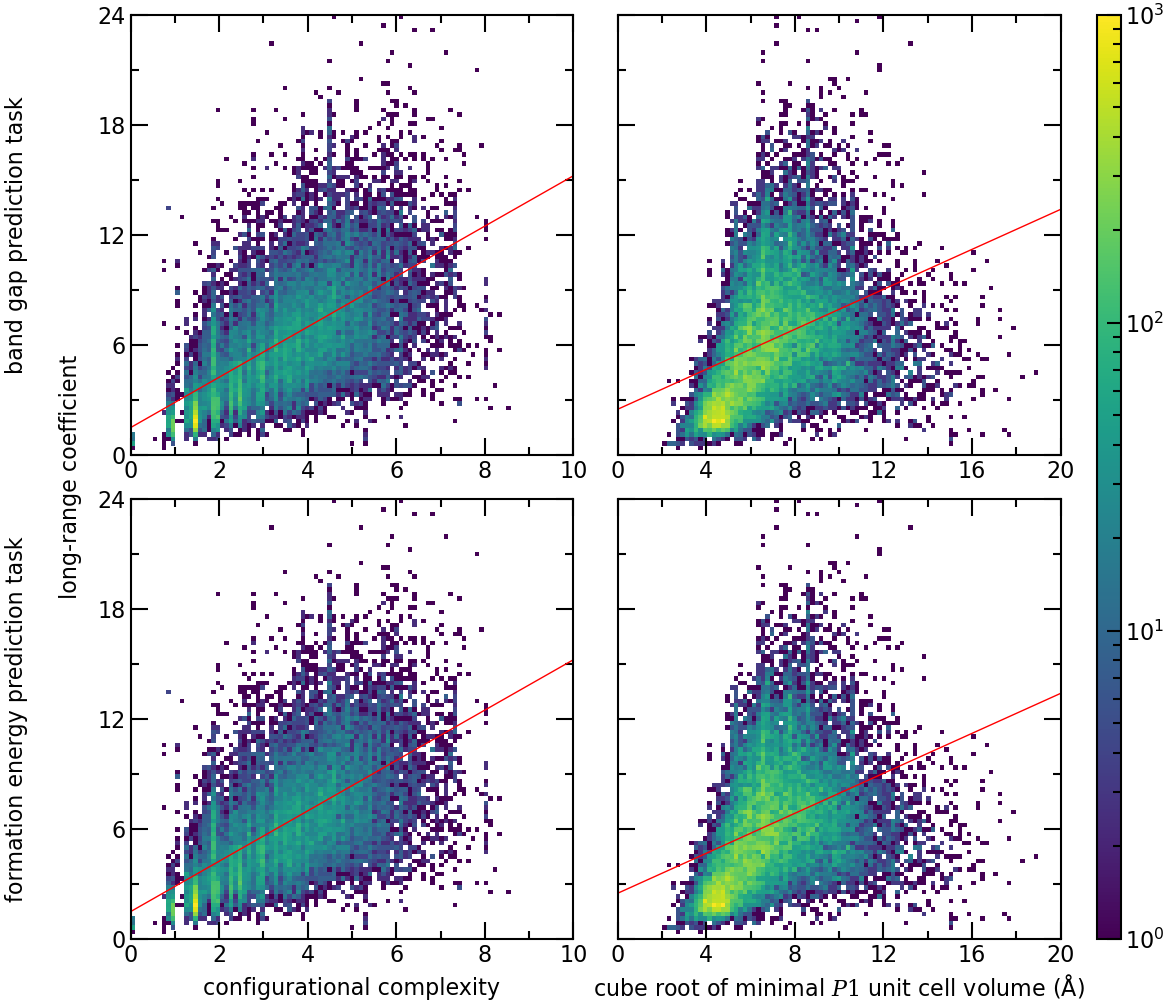

In [20]:
complexities_bandgap = "" #Insert path to output from CrystIT for band gap here
complexities_formationenergy = "" #Insert path to output from CrystIT for formation energy here

font = {'size'   : 16}
mlp.rc('font', **font)
mlp.rcParams['axes.linewidth'] = 1.5

fig,ax = plt.subplots(2, 2, sharex=False, sharey=True,gridspec_kw={'wspace':0.1, 'hspace':0.1},figsize=(12,12))

#Plot the complexities

import re
complexity = pd.read_csv(complexities_bandgap,sep=";")
complexity.index = complexity[" Path"].apply(lambda x: int(re.findall(r'\d+',x)[0])).sort_index() #Makes sure the index matches the cif file names
complexity = complexity.sort_index()
def na_filter(series,filter):
    return series[filter.notna()]

x = na_filter(complexity[" I_conf"],complexity[" I_conf"])
y = na_filter(df_live_bandgap["2m"],complexity[" I_comb"])
print(len(complexity[" I_comb"]))
print(len(x))
print(len(df_live_bandgap["2m"]))
print(len(y))
ax[0,0].hist2d(na_filter(x,x),na_filter(y,x),bins=[np.linspace(0,10,100),np.linspace(0,24,100)],norm=mlp.colors.LogNorm())
ax[0,0].set_ylim(0,6)
ax[0,0].set_xlim(0,10)
ax[0,0].set_ylabel("LR coefficient")
#ax[0,0].set_xlabel("Configurational Complexity")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax[0,0].plot([0,30], p([0,30]),color='red')

complexity = pd.read_csv(complexities_formationenergy,sep=";")
complexity.index = complexity[" Path"].apply(lambda x: int(re.findall(r'\d+',x)[0])).sort_index() #Makes sure the index matches the cif file names
complexity = complexity.sort_index()

x = na_filter(complexity[" I_conf"],complexity[" I_conf"])
y = na_filter(df_live_formationenergy["2m"],complexity[" I_comb"])
ax[1,0].hist2d(na_filter(x,x),na_filter(y,x),bins=[np.linspace(0,10,100),np.linspace(0,24,100)],norm=mlp.colors.LogNorm())
ax[1,0].set_ylim(0,6)
ax[1,0].set_xlim(0,10)
ax[1,0].set_ylabel("long-range coefficient")
ax[1,0].yaxis.labelpad = 10
ax[1,0].set_xlabel("configurational complexity")
ax[1,0].xaxis.labelpad = 7.53
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax[1,0].plot([0,30], p([0,30]),color='red')

x = df_live_bandgap["Primitive_Volume"]**(1/3)
y = df_live_bandgap["2m"]

ax[0,1].hist2d(x,y,bins=[np.linspace(0,20,100),np.linspace(0,24,100)],norm=mlp.colors.LogNorm())
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax[0,1].plot([0,30], p([0,30]),color='red')
#ax[0,1].set_xlabel("cube root of unit cell volume (Å)")
ax[0,1].set_ylim(0,8)
ax[0,1].set_xlim(0,20)

x = df_live_formationenergy["Primitive_Volume"]**(1/3)
y = df_live_formationenergy["2m"]

ax[1,1].hist2d(x,y,bins=[np.linspace(0,20,100),np.linspace(0,24,100)],norm=mlp.colors.LogNorm())
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax[1,1].plot([0,30], p([0,30]),color='red')
ax[1,1].set_xlabel("cube root of minimal $P1$ unit cell volume (Å)")
ax[1,1].set_ylim(0,24)
ax[1,1].set_xlim(0,20)

#ax[0,0].set_xlabel("configurational complexity")
#ax[0,0].xaxis.set_label_position('top')
#ax[0,0].xaxis.labelpad = 15
#ax[0,1].set_xlabel("cube root of primitive unit cell volume")
#ax[0,1].xaxis.set_label_position('top')
#ax[0,1].xaxis.labelpad = 15
ax[0,0].set_ylabel("band gap prediction task")
ax[0,0].yaxis.labelpad = 50
ax[1,0].set_ylabel("formation energy prediction task")
ax[1,0].yaxis.labelpad = 50

for i in range(2):
    for j in range(2):
        ax[i,j].tick_params(length=12,width=1.5)
        ax[i,j].tick_params(which="minor",length=6,width=1.5)
        ax[i,j].xaxis.set_major_locator(plt.MaxNLocator(5))
        ax[i,j].xaxis.set_minor_locator(plt.MaxNLocator(10))
        ax[i,j].yaxis.set_major_locator(plt.MaxNLocator(4))
        ax[i,j].yaxis.set_minor_locator(plt.MaxNLocator(8))

shadowaxes = fig.add_subplot(111, xticks=[], yticks=[], frame_on=False)
shadowaxes.yaxis.labelpad = 35
shadowaxes.xaxis.labelpad = 25
#shadowaxes.xaxis.label.set_size(22)
#shadowaxes.yaxis.label.set_size(22)
shadowaxes.set_ylabel("long-range coefficient")
cbar_ax = fig.add_axes([0.93, 0.11, 0.02, 0.77])

sm = plt.cm.ScalarMappable(cmap="viridis", norm=mlp.colors.LogNorm(1,1000))
cb = fig.colorbar(sm,cax=cbar_ax)
cb.ax.tick_params(length=10,width=1.5)
cb.ax.tick_params(which="minor",length=6,width=1.5)
plt.savefig("Long Range Analysis")
plt.show()